In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras

RSEED = 42
dataset_path = '../data/images/'

In [2]:


#import the data

data = []

# Specify the path to your dataset
dataset_path = '../data/images/'

# Iterate through each plant folder
for plant_class in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, plant_class)
    
    # Iterate through each image in the plant folder
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        data.append({'Image_Path': image_path, 'Class': plant_class})

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

df

,Image_Path,Class
0,../data/images/Tomato___spider_mites/fa05ccd2-...,Tomato___spider_mites
1,../data/images/Tomato___spider_mites/fd3b6292-...,Tomato___spider_mites
2,../data/images/Tomato___spider_mites/82306885-...,Tomato___spider_mites
3,../data/images/Tomato___spider_mites/9c7f0991-...,Tomato___spider_mites
4,../data/images/Tomato___spider_mites/d7c5cad4-...,Tomato___spider_mites
...,...,...
95863,../data/images/Soybean___healthy/57c18b39-2a33...,Soybean___healthy
95864,../data/images/Soybean___healthy/4fdc663e-a8ea...,Soybean___healthy
95865,../data/images/Soybean___healthy/df807f13-078b...,Soybean___healthy
95866,../data/images/Soybean___healthy/60bf9858-951a...,Soybean___healthy


In [3]:
def rename_subfolder(parent_dir, subfolder_name, new_name):
    subfolder_path = os.path.join(parent_dir, subfolder_name)
    new_path = os.path.join(parent_dir, new_name)

    # Check if the subfolder exists
    if os.path.exists(subfolder_path):
        # Rename the subfolder
        os.rename(subfolder_path, new_path)
        print(f"{subfolder_name} renamed to {new_name} successfully.")
    else:
        print(f"Subfolder {subfolder_name} doesn't exist in {parent_dir}.")

# Example usage
parent_dir = "../data/images/"
subfolder_name = "Grape_leaf_blight"
new_name = "Grape___leaf_blight"

rename_subfolder(parent_dir, subfolder_name, new_name)

Subfolder Grape_leaf_blight doesn't exist in ../data/images/.


In [4]:
# Extract plant types from class names
df['plant_type'] = df['Class'].apply(lambda x: x.split('___')[0])

# Count the occurrences of each plant type
plant_type_counts = df['plant_type'].value_counts()

# Display the count of each plant type
print(plant_type_counts)

plant_type
Cassava        21397
Tomato         18160
Potato          8552
Apple           6542
Grape           6232
Rice            5704
Orange          5507
Soybean         5090
Corn            3852
Peach           2657
Sugercane       2521
Bell_pepper     2475
Cherry          1906
Squash          1835
Strawberry      1565
Blueberry       1502
Raspberry        371
Name: count, dtype: int64


In [5]:
# Extract disease types from class names
df['disease_type'] = df['Class'].apply(lambda x: x.split('___')[1])

# Count the occurrences of each disease type
disease_type_counts = df['disease_type'].value_counts()

# Display the count of each disease type
print(disease_type_counts)

disease_type
healthy                 21615
mosaic_disease          13158
citrus_greening          5507
bacterial_spot           5421
leaf_curl                5357
late_blight              3929
early_blight             3628
powdery_mildew           2887
bacterial_blight         2671
green_mottle             2386
black_measles            2271
brown_streak_disease     2189
brown_spot               1815
black_rot                1801
septoria_leaf_spot       1771
rust                     1755
spider_mites             1676
blast                    1440
target_spot              1404
scab                     1222
common_rust              1192
leaf_scorch              1109
tungro                   1080
isariopsis_leaf_spot     1076
northern_leaf_blight      985
leaf_mold                 952
pests                     611
bacterial_wilt            569
virus                     532
red_rot                   518
gray_leaf_spot            513
yellow_leaf               505
mosaic                    4

In [6]:
labels = np.unique(df['disease_type']).tolist()

labels

['alternaria_leaf_spot',
 'bacterial_blight',
 'bacterial_spot',
 'bacterial_wilt',
 'black_measles',
 'black_rot',
 'blast',
 'brown_spot',
 'brown_streak_disease',
 'citrus_greening',
 'common_rust',
 'early_blight',
 'gray_leaf_spot',
 'gray_spot',
 'green_mottle',
 'healthy',
 'isariopsis_leaf_spot',
 'late_blight',
 'leaf_blight',
 'leaf_curl',
 'leaf_mold',
 'leaf_scorch',
 'mosaic',
 'mosaic_disease',
 'mosaic_virus',
 'nematode',
 'northern_leaf_blight',
 'pests',
 'phytophthora',
 'powdery_mildew',
 'red_rot',
 'rust',
 'scab',
 'septoria_leaf_spot',
 'spider_mites',
 'target_spot',
 'tungro',
 'virus',
 'yellow_leaf']

In [7]:
# split the data train and test data into different folders

# import os
import shutil
from sklearn.model_selection import train_test_split

# Split data into features (image paths) and labels (classes)
X = df['Image_Path']
y = df['disease_type']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define paths for the training and testing data folders
train_dir = '../data/train/'
test_dir = '../data/test/'

# Create directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Copy images to the training folder
for image_path, label in zip(X_train, y_train):
    dest_folder = os.path.join(train_dir, label)
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    shutil.copy(image_path, dest_folder)

# Copy images to the testing folder
for image_path, label in zip(X_test, y_test):
    dest_folder = os.path.join(test_dir, label)
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    shutil.copy(image_path, dest_folder)


In [8]:
def load_preprocess_split_train_val(data_path):
    '''
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df,
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split = 0.2,
        subset = "both",
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image

In [9]:
train_dataset_path = '../data/train/'

In [10]:
train_ds, val_ds = load_preprocess_split_train_val(train_dataset_path)

Found 76694 files belonging to 39 classes.
Using 61356 files for training.
Using 15338 files for validation.


In [12]:
import tensorflow.keras.backend as K
from tensorflow.keras.applications import DenseNet121
K.clear_session()

#1. Select the convolutional base / Pretrained network
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [13]:
#2. Freeze the weights in order to not retrain the loaded pre-trained model
base_model.trainable= False

In [14]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [15]:
# 3. Create your model with pretrained network as base model
inputs = Input(shape=(224,224,3))

base = base_model(inputs)

# can also add additional cnn layers if necessary

# dont forget to flatten out before the final layer
flatten = GlobalAveragePooling2D()(base)

outputs = Dense(39,activation='softmax')(flatten)

model_tf = Model(inputs,outputs)

In [16]:
model_tf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 39)                39975     
                                                                 
Total params: 7077479 (27.00 MB)
Trainable params: 39975 (156.15 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [17]:
model_tf.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_tf.fit(train_ds,
          #verbose=2, # how the training log should get printed 
          epochs=10,
          validation_data=val_ds)

Epoch 1/10
1918/1918 [==============================] - 2320s 1s/step - loss: 1.2925 - accuracy: 0.6447 - val_loss: 0.8650 - val_accuracy: 0.7434
Epoch 2/10
1918/1918 [==============================] - 2338s 1s/step - loss: 0.8371 - accuracy: 0.7485 - val_loss: 0.8660 - val_accuracy: 0.7709
Epoch 3/10
1918/1918 [==============================] - 2372s 1s/step - loss: 0.7555 - accuracy: 0.7714 - val_loss: 0.7721 - val_accuracy: 0.7735
Epoch 4/10
1918/1918 [==============================] - 2365s 1s/step - loss: 0.6999 - accuracy: 0.7864 - val_loss: 0.7549 - val_accuracy: 0.7715
Epoch 5/10
1918/1918 [==============================] - 2355s 1s/step - loss: 0.6649 - accuracy: 0.7935 - val_loss: 0.7990 - val_accuracy: 0.7945
Epoch 6/10
1918/1918 [==============================] - 2353s 1s/step - loss: 0.6519 - accuracy: 0.7999 - val_loss: 0.7160 - val_accuracy: 0.7837
Epoch 7/10
1918/1918 [==============================] - 2337s 1s/step - loss: 0.6232 - accuracy: 0.8087 - val_loss: 0.7049 -

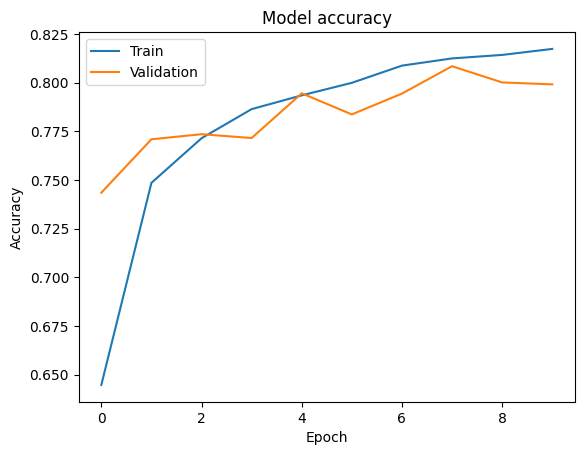

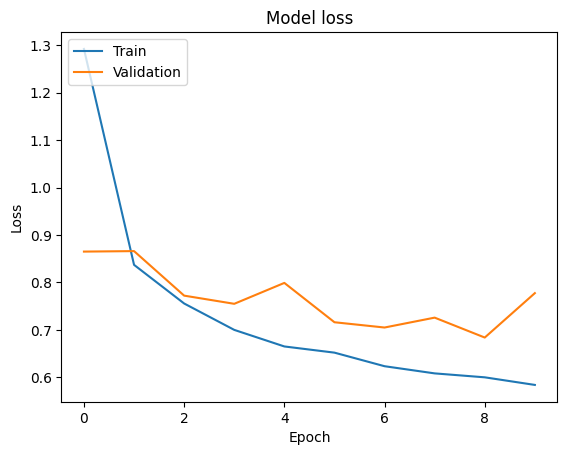

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()